# Data 512 A1

This assignment involves the following:
* Gathering data about monthly traffic on English Wikipedia from January 1, 2008 through August 30, 2020 through the Wikimedia Legacy Pagecounts API and Pageviews API
* Processing the data into the proper format for analysis
* Analyzing the data through a visualization

# Step 1: Gathering the Data

In order to make calls to the Wikimedia APIs, we first need to import the json and requests libraries.

In [1]:
import json
import requests

Here, we declare the request endpoints:
* `endpoint_legacy`: Legacy Pagecounts API
* `endpoint_pageviews`: Pageviews API.

In [2]:
# request endpoints
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

Below are the parameters for all the different API calls that need to be made:
* `desktop_params_legacy`: desktop site visits with Legacy Pagecounts API
* `mobile_params_legacy`: mobile site visits with Legacy Pagecounts API
* `desktop_params_pageviews`: desktop site visits with Pageviews API
* `mobile_params_pageviews`: mobile site visits with Pageviews API
* `mobile_app_params_pageviews`: mobile app visits with Pageviews API

For the Pageviews API, we set agent to "user" because we want to filter out traffic from crawlers or spiders.

In [3]:
# params for legacy pagecount
desktop_params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2008010100",
                 "end" : "2020090100"
                    }
mobile_params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2008010100",
                 "end" : "2020090100"
                    }

# params for pageviews
desktop_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2008010100",
                    "end" : '2020090100'
                        }
mobile_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2008010100",
                    "end" : '2020090100'
                        }
mobile_app_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2008010100",
                    "end" : '2020090100'
                        }

# header info
headers = {
    'User-Agent': 'https://github.com/vaneshsu99',
    'From': 'vaneshsu@uw.edu'
}

`api_call` is a function that can be used to make an API call. It takes in two parameters and returns the API's response. The two parameters are:
* `endpoint`: the endpoint for the API call
* `parameters`: the parameters for the API call (see block above for example parameters)

In [4]:
# function for api call
# takes in endpoint and param dict
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

Next, we use the `api_call` function to make five different API calls to gather information about monthly views on the desktop and mobile sites from the Legacy Pagecounts API and desktop, mobile, and mobile app views from the Pageviews API.

In [5]:
# make all 5 api calls
desktop_legacy = api_call(endpoint_legacy, desktop_params_legacy)
mobile_legacy = api_call(endpoint_legacy, mobile_params_legacy)
desktop_pageviews = api_call(endpoint_pageviews, desktop_params_pageviews)
mobile_pageviews = api_call(endpoint_pageviews, mobile_params_pageviews)
mobile_app_pageviews = api_call(endpoint_pageviews, mobile_app_params_pageviews)

`save_json` is a function that can be used to save json data to files. It takes in two parameters:
* `filename`: name of file
* `data`: the json data

In [6]:
# function for saving data to json files
def save_json(filename, data):
    with open(filename, 'w') as file:
        json.dump(data, file)

All five API json responses are saved to separate files with the naming convention `apiname_accesstype_firstmonth-lastmonth.json`

In [7]:
# save data to json files
save_json('pagecounts_desktop-site_200801-202008.json', desktop_legacy)
save_json('pagecounts_mobile-site_200801-202008.json', mobile_legacy)
save_json('pageviews_desktop_200801-202008.json', desktop_pageviews)
save_json('pageviews_mobile-site_200801-202008.json', mobile_pageviews)
save_json('pageviews_mobile-app_200801-202008.json', mobile_app_pageviews)

# Step 2: Processing the Data

Next we want to process the data and get it into a format we can work with to create our final visualization. The block below contains the names of the final columns we want.

In [8]:
# final columns we want
columns = ['year', 
           'month', 
           'pagecount_all_views', 
           'pagecount_desktop_views', 
           'pagecount_mobile_views', 
           'pageview_all_views',
           'pageview_desktop_views',
           'pageview_mobile_views'
          ]

In order to process the data, we will be importing and using the pandas library.

In [9]:
import pandas as pd

The first thing we want to do is combine the mobile-site and mobile-app Pageview data. In order to do that we will first convert the json data into pandas dataframes. This leaves us with a dataframe for the mobile-site pageviews data and a dataframe for the mobile-app pageviews data. Notice that we're specifically grabbing "items". This is because all the data is contained within an array called "items".

In [10]:
# turn mobile pageview json to dataframes
mobile_pageviews_df = pd.DataFrame(mobile_pageviews['items'])
mobile_app_pageviews_df = pd.DataFrame(mobile_app_pageviews['items'])

Next, we will sum the mobile-site and mobile-app pageviews and create a new dataframe with these combined views, their corresponding timestamps, and their access type - `pageview_mobile_views`. This value was chosen specifically because it is one of the columns we eventually want to have in our final dataset.

In [11]:
# sum mobile web pageviews and mobile app pageviews
mobile_combined_pageviews = mobile_pageviews_df['views'] + mobile_app_pageviews_df['views']
mobile_combined_pageviews_df = pd.DataFrame({'access': 'pageview_mobile_views', 'timestamp':mobile_pageviews_df['timestamp'], 'views':mobile_combined_pageviews})

Now, we go through the rest of the json data, convert them to dataframes, and select only the relevant columns - timestamp and count/views.
For each dataset, we will add in a column describing the access type like we did previously with the mobile pageviews data.

In [12]:
# desktop legacy, mobile legacy, desktop pageviews to dataframes
# select only relevant columns
# assign column with type of access (future column name for pivot later)
desktop_legacy_df = pd.DataFrame(desktop_legacy['items'], columns=['timestamp', 'count']).assign(access='pagecount_desktop_views')
desktop_legacy_df.rename(columns={'count': 'views'}, inplace=True)
mobile_legacy_df = pd.DataFrame(mobile_legacy['items'], columns=['timestamp', 'count']).assign(access='pagecount_mobile_views')
mobile_legacy_df.rename(columns={'count': 'views'}, inplace=True)
desktop_pageviews_df = pd.DataFrame(desktop_pageviews['items'], columns=['timestamp', 'views']).assign(access='pageview_desktop_views')

The separate dataframes are now concatenated into one dataframe containing data from all 5 API calls.

In [13]:
# concat dataframes from all sources
wiki_traffic_df = pd.concat([desktop_legacy_df, mobile_legacy_df, desktop_pageviews_df, mobile_combined_pageviews_df])
wiki_traffic_df.head()

,timestamp,views,access
0,2008010100,4930902570,pagecount_desktop_views
1,2008020100,4818393763,pagecount_desktop_views
2,2008030100,4955405809,pagecount_desktop_views
3,2008040100,5159162183,pagecount_desktop_views
4,2008050100,5584691092,pagecount_desktop_views


Next, we pivot the dataframe so the different access types become columns. The index is reset so the timestamp column is not used as an index, the NaN values are filled with 0's, and the name for the columns is removed because it's not necessary.

In [14]:
# pivot type of access to columns
# fill NAs with 0s
wiki_traffic_df_pivot = wiki_traffic_df.pivot_table(index='timestamp', columns='access', values='views').reset_index().fillna(0)
wiki_traffic_df_pivot.columns.name=None

The block below creates the `pagecount_all_views` and `pageview_all_views` columns by summing pagecount and pageview desktop and mobile views.

In [15]:
# sum total pagecount and pageviews to create two new columns with totals
wiki_traffic_df_pivot = wiki_traffic_df_pivot.assign(
    pagecount_all_views=wiki_traffic_df_pivot['pagecount_desktop_views']+wiki_traffic_df_pivot['pagecount_mobile_views'],
    pageview_all_views=wiki_traffic_df_pivot['pageview_desktop_views']+wiki_traffic_df_pivot['pageview_mobile_views']
)

We can view the pivoted data structure with the code in the block below.

In [16]:
# view pivoted data structure
wiki_traffic_df_pivot.head()

,timestamp,pagecount_desktop_views,pagecount_mobile_views,pageview_desktop_views,pageview_mobile_views,pagecount_all_views,pageview_all_views
0,2008010100,4.930903e+09,0.0,0.0,0.0,4.930903e+09,0.0
1,2008020100,4.818394e+09,0.0,0.0,0.0,4.818394e+09,0.0
2,2008030100,4.955406e+09,0.0,0.0,0.0,4.955406e+09,0.0
3,2008040100,5.159162e+09,0.0,0.0,0.0,5.159162e+09,0.0
4,2008050100,5.584691e+09,0.0,0.0,0.0,5.584691e+09,0.0


Next, we want to create the year and month columns. In order to do this, the `timestamp` values are split into year and month and assigned to their respective columns.

In [27]:
# split timestamp for year and month columns
wiki_traffic_df_pivot = wiki_traffic_df_pivot.assign(year=wiki_traffic_df_pivot['timestamp'].str[0:4], month=wiki_traffic_df_pivot['timestamp'].str[4:6])

Finally, we put the columns in the correct order and save the dataset to a csv file called `en-wikipedia_traffic_200712-202008.csv`.

In [18]:
# reorder final columns
wiki_traffic_final = wiki_traffic_df_pivot[columns]

We can take a look at our final data structure using the clode in the block below.

In [19]:
# view final data structure
wiki_traffic_final.head()

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2008,01,4.930903e+09,4.930903e+09,0.0,0.0,0.0,0.0
1,2008,02,4.818394e+09,4.818394e+09,0.0,0.0,0.0,0.0
2,2008,03,4.955406e+09,4.955406e+09,0.0,0.0,0.0,0.0
3,2008,04,5.159162e+09,5.159162e+09,0.0,0.0,0.0,0.0
4,2008,05,5.584691e+09,5.584691e+09,0.0,0.0,0.0,0.0


In [20]:
# save to csv
wiki_traffic_final.to_csv('en-wikipedia_traffic_200712-202008.csv', index=False)

# Step 3: Analyze the Data

The last step is to analyze the data through a visualization. The matplotlib and numpy libraries are imported to help with this. pyplot will help with the plotting and mdates will help with identifying the years we want to show on the x-axis.

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

Instead of 0 values, we will replace those with NaNs so they don't show up on the graph.
In order to make graphing the dates easier, we will add a date column that contains datetime values created from the year and month columns.

In [48]:
# replace 0s with NaN so they don't show up on graph
wiki_traffic_final_nan = wiki_traffic_final.replace(0, np.nan)
# add datetime for graph
wiki_traffic_date = wiki_traffic_final_nan.assign(date=pd.to_datetime(wiki_traffic_final_nan[['year', 'month']].assign(day=1)))

Last but not least, matplotlib is used to create a graph showing views across all the different sources from January 1, 2008 through August 30, 2020.

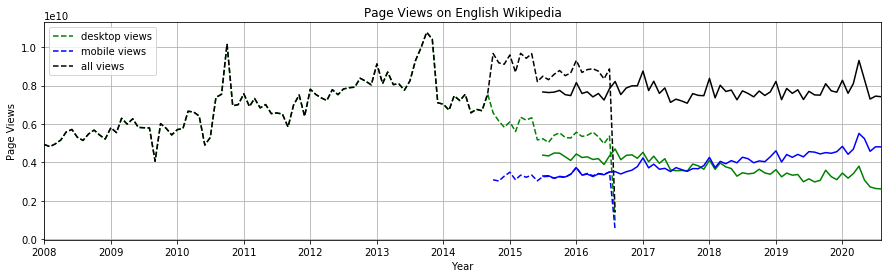

In [49]:
fig, ax = plt.subplots()
fig.set_size_inches(15,4)
year = mdates.YearLocator()
ax.xaxis.set_major_locator(year)
ax.plot('date', 'pagecount_desktop_views', 'g--', data=wiki_traffic_date)
ax.plot('date', 'pagecount_mobile_views', 'b--', data=wiki_traffic_date)
ax.plot('date', 'pagecount_all_views', 'k--', data=wiki_traffic_date)
ax.plot('date', 'pageview_desktop_views', 'g', data=wiki_traffic_date)
ax.plot('date', 'pageview_mobile_views', 'b', data=wiki_traffic_date)
ax.plot('date', 'pageview_all_views', 'k', data=wiki_traffic_date)
ax.grid(True)
ax.set_xlim(wiki_traffic_date['date'][0], wiki_traffic_date['date'][len(wiki_traffic_date)-1])
ax.set_xlabel('Year')
ax.set_ylabel('Page Views')
ax.set_title('Page Views on English Wikipedia')
plt.legend(['desktop views', 'mobile views', 'all views'])
fig.show()